# Figure 7: Known background

In [1]:
import gzip
import pickle
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["text.usetex"] =  True

import common
from common import draw_limits, sketch_dist, log_x
import hypney.all as hp

def powerlaw(similarity, mu):
    return hp.powerlaw(a=1/similarity, rate=mu)

mu_signal = hp.DEFAULT_RATE_GRID
mu_signal_clip = mu_signal[mu_signal < 100][1:]  # For Yellin Hawk
signal = hp.uniform().fix_except('rate')
background = powerlaw

In [2]:
statistics = dict(

    lr_fullspace = dict(
        stat_class=hp.SignedPLR,
        label='$t$ in full space',
        dist_filename='fulllr_fullspace_powerlaw_{similarity:.3f}_{mu_bg:.3f}',
        n_toys_dist=1000,
        color='k',
        n_old=2500,
    ),
    
#     pn_allmu = dict(
#         stat_class=hp.PNAllRegionHawk,
#         # Statistic distribution is independent of model PDF;
#         # use the background-free one we already have
#         dist_filename='pn_all',
#         label='PN',
#         color='g'
#     ),
#     pn_sigmu = dict(
#         stat_class=hp.PNAllRegionHawk,
#         calculate_bgfree=True,
#         # Distribution depends on background shape;
#         # statistic uses bg-free model for calculations.
#         dist_filename='pn_all_sigmu_powerlaw_{similarity:.3f}_{mu_bg:.3f}',
#         #style=dict(color='g')
#         color='b',
#     ),


#     lr_s5_bgfree_allmu = dict(
#         stat_class=hp.FixedRegionSimpleHawk,
#         stat_kwargs=dict(cuts=hp.uniform_sn_cuts(5)),
#         #dist_filename='lr_s5',
#         #abel='$H[t_0, S_5]$, joint model',
#         color='violet',
#     ),
#     lr_s5_sigmu = dict(
#         stat_class=hp.FixedRegionSimpleHawk,
#         stat_kwargs=dict(cuts=hp.uniform_sn_cuts(5)),
#         calculate_bgfree=True,
#         # Distribution depends on background shape;
#         # statistic uses bg-free model for calculations.
#  WRONG!!! dist is bg-dependent
#         dist_filename='lr_s5_sigmu_powerlaw_{similarity:.3f}_{mu_bg:.3f}',
#         #style=dict(color='orangered', linestyle='--')
#         label=r'$H[t_0, S_5]$, adjusted $C_\alpha$',
#         color='olive',
#         n_toy_limits=250,
#     ),
#     lr_s5_sigmu_ignore_knownbg = dict(
#         stat_class=hp.FixedRegionSimpleHawk,
#         stat_kwargs=dict(cuts=hp.uniform_sn_cuts(5)),
#         calculate_bgfree=True,
#         dist_filename='lr_s5',
#         label=r'$H[t_0, S_5]$, ignore bg.',
#         color='maroon',
#         n_toy_limits=250,
#     ),
    
    
    lr_bgfree_allmu = dict(
        stat_class=hp.AllRegionSimpleHawk,
        # Statistic distribution is independent of model PDF;
        # use the background-free one we already have
        dist_filename='lr_all',
        label='$H[t_0, I]$, joint model',
        color='purple',
        n_old=2500,
    ),
    lr_sigmu = dict(
        stat_class=hp.AllRegionSimpleHawk,
        calculate_bgfree=True,
        # Distribution depends on background shape;
        # statistic uses bg-free model for calculations.
        # TODO: upload these dists to github (many of them, so takes space)
        dist_filename='lr_all_sigmu_powerlaw_{similarity:.3f}_{mu_bg:.3f}',
        #style=dict(color='orangered', linestyle='--')
        label=r'$H[t_0, I]$, adjusted $Q_\alpha$',
        color='g',
        n_old=2500,
        # Not sure this was correct, dist filename weird
    ),
    
    lr_s5 = dict(
        stat_class=hp.FixedRegionFullHawk,
        calculate_bgfree=False,
        # TODO: upload these dists to github (many of them, so takes space)
        dist_filename='fulllr_s5_powerlaw_{similarity:.3f}_{mu_bg:.3f}',
        stat_kwargs=dict(cuts=hp.uniform_sn_cuts(5)),
        #style=dict(color='orangered', linestyle='--')
        label=r'$H[t, S_5]$',
        n_toys_dist=250,
        color='b',
        n_toy_limits=1500,
        n_old=1500,
    ),
    
    lr_sigmu_ignore_knownbg = dict(
        stat_class=hp.FixedRegionSimpleHawk,
        stat_kwargs=dict(cuts=hp.uniform_sn_cuts(5)),
        calculate_bgfree=True,
        dist_filename='lr_all',
        label=r'$H[t_0, I]$, ignore bg.',
        color='r',
        n_old=2500,
    ),

    
    
#     cn_allmu = dict(
#         # Statistic distribution is independent of model PDF;
#         # use the background-free one we already have
#         stat_class=hp.YellinCNHawk,
#         dist_filename='yellin_cn_149max',
#         color='darkorange',
#         label='CN'
#     ),

    
)

In [3]:
# Avoid 0, but make sure to hit 0.5 and 1
similarities = np.concatenate([
    np.linspace(1e-3, 0.5, 7), 
    np.linspace(0.5, 1, 7)[1:]])

high_bg = False    # For future extension to higher bgs (need more dists generation though)
n_toy_limits = 5000
mu_bgs = np.concatenate([
    np.array([0.2, 1]),
    np.geomspace(2, 100, 1 + 15)
])

with gzip.open('poisson_sens.pkl.gz', mode='rb') as f:
    poisson_sens = pickle.load(f)
poisson_sens = poisson_sens['regular']

In [4]:
%%time
# 250 toys, S5: 1h 49min 56s

cache_folder = Path(f'./limits_knownbg{"_hibg" if high_bg else ""}/')
cache_folder.mkdir(exist_ok=True)

def init_statistic(s, similarity, mu_bg):
    bg_only = background(similarity, mu_bg).freeze()

    # Initialize statistic
    stat_kwargs = s.get('stat_kwargs', dict())

    if s.get('calculate_bgfree'):
        stat_kwargs['signal_only'] = True
        stat = s['stat_class'](signal, **stat_kwargs)
    else:
        stat = s['stat_class'](signal + bg_only, **stat_kwargs)

    if s['dist_filename']:
        # Load distribution. Don't build it here, we're already in a ProcessPool worker task
        dist_fn = s['dist_filename'].format(
            similarity=similarity,
            mu_bg=mu_bg)
        stat = stat.with_stored_dist(
            dist_fn,
            build_if_not_found=False,
            n_toys=s.get('n_toys_dist', 10_000))
    return stat


def draw_all_limits(similarity, *, s, n_to_draw):
    results = np.zeros((len(mu_bgs), n_to_draw))
    for mu_i, mu_bg in enumerate(mu_bgs):

        bg_only = background(similarity, mu_bg).freeze()
        stat = init_statistic(s, similarity, mu_bg)

        # Get toy limits
        anchors = (mu_signal_clip if isinstance(stat, hp.YellinCNHawk) else mu_signal)
        ul = hp.UpperLimit(stat, anchors=list(anchors))
        results[mu_i] = draw_limits(ul, bg_only, n_to_draw)
    return results
    

for stat_name, s in statistics.items():

    n_toys = s.get('n_toy_limits', n_toy_limits)
    limits_fn = cache_folder / f'{stat_name}_{len(similarities)}_{len(mu_bgs)}_{n_toys}{"_hibg" if high_bg else ""}.pkl.gz'
    if limits_fn.exists():
        with gzip.open(limits_fn, mode='rb') as f:
            s['limits'] = pickle.load(f)
    else:        
        # Bahh code duplication
        if high_bg:
            n_old = 0
        else:
            n_old = s.get('n_old', 0)
        if n_old:
            old_limits_fn = cache_folder / f'{stat_name}_{len(similarities)}_{len(mu_bgs)}_{n_old}.pkl.gz'
            with gzip.open(old_limits_fn, mode='rb') as f:
                old_limits = pickle.load(f)
       
        n_to_draw = n_toys - n_old
        print(f"Running {n_to_draw} toy mcs for {stat_name}")
        with ProcessPoolExecutor(max_workers=min(7, len(similarities))) as exc:
            new_limits = np.stack(list(exc.map(
                partial(draw_all_limits, s=s, n_to_draw=n_to_draw),
                similarities)))
        s['limits'] = np.concatenate([old_limits, new_limits], axis=2)

        with gzip.open(limits_fn, mode='wb') as f:
            pickle.dump(s['limits'], f)

CPU times: user 194 ms, sys: 20.2 ms, total: 214 ms
Wall time: 215 ms


In [5]:
statistics.keys()

dict_keys(['lr_fullspace', 'lr_bgfree_allmu', 'lr_sigmu', 'lr_s5', 'lr_sigmu_ignore_knownbg'])

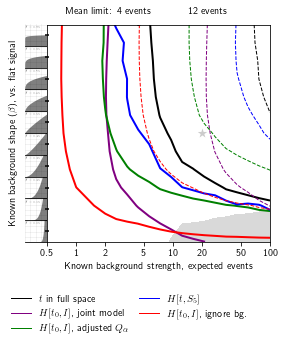

In [12]:
# Simple figure for talks
simple = False

levels, linestyles, linewidths = np.array([4, 12]), ['-', '--'], [2, 1]


fig = plt.figure(figsize=(4,4))

for statname, s in statistics.items():
    if simple and statname in ['lr_bgfree_allmu', 'lr_sigmu']:
        continue
    
    s['sensitivity'] = y = np.mean(s['limits'], axis=2)
    color = s['color']

    for level, linestyle, lw in zip(levels, linestyles, linewidths):
        plt.contour(mu_bgs, similarities, y,
                    levels=[level],
                    norm=matplotlib.colors.LogNorm(1, 100),
                    linewidths=lw,
                    linestyles=linestyle,
                    colors=color)
    # Null line plot, so legend has something
    plt.plot([0], [0], 
             label=s.get('label', statname), 
             linestyle='-',
             color=color, 
             linewidth=lw) 

legend = plt.legend(
    loc='upper left',
    #bbox_to_anchor=(1.15, 1),
    bbox_to_anchor=(-0.2, -0.2),
    ncol=2,
    columnspacing=1,
    frameon=False,)

# Indicate third-best method
# r = statistics['lr_sigmu']['sensitivity'] / statistics['lr_bgfree_allmu']['sensitivity']
# plt.contourf(
#     mu_bgs, similarities, r,
#     levels=[1, 10],
#     colors='purple', alpha=0.15)
# plt.contourf(
#     mu_bgs, similarities, r,
#     levels=[0, 1],
#   colors='g', alpha=0.15)

# Indicate where joint model method is worse than ignoring background
if not simple:
    r = statistics['lr_bgfree_allmu']['sensitivity'] / statistics['lr_sigmu_ignore_knownbg']['sensitivity']
    plt.contourf(
        mu_bgs, similarities, r,
        levels=[1, 10],
        colors='k', alpha=0.15)


plt.ylabel(r"Known background shape ($\beta$), vs. flat signal", labelpad=29)
plt.ylim(0, 1)
plt.yticks([])

plt.xlabel(r"Known background strength, expected events")
log_x(0.5, 100 + 1e-9, tick_at=[1, 2, 5])
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))


# Mean limit contour labels
ypos = 1.05
for i, l in enumerate(levels):
    xpos = np.exp(np.interp(np.log(l), np.log(statistics['lr_bgfree_allmu']['sensitivity'][-1]), np.log(mu_bgs)))
    msg = ('Mean limit: ' if i == 0 else '') + f'{l} events'
    plt.text(xpos, ypos, msg, ha='center')

# For future reference
plt.scatter(20, 0.5, marker='*', c='k', linewidths=0, s=100, alpha=0.2)

# Distribution sketches
n_sketch = 10
width = 0.1
xpos = 0.04825
sketch_sims = np.linspace(0, 1, n_sketch * 2 + 1)[1::2]
plt.scatter(
    0.5 + 0 * sketch_sims,
    sketch_sims, 
    marker='_', s=10, c='k', 
    clip_on=False,
    zorder=-50)
y_start = 0.125  # y matching lower spine
y_end = 0.882    # y matching upper spine
width = (y_end - y_start) / n_sketch
for i, sim in enumerate(sketch_sims):
    new_ax = fig.add_axes([xpos, y_start + i * width, 
                          width, width])
    new_ax.set_zorder(-5)
    plt.sca(new_ax)
    sketch_dist(common.powerlaw(mu=1, alpha=sim), 
                xlabel=None, annotation=rf"$\beta = {sim:0.2f}$")

for fmt in 'png', 'pdf':
    plt.savefig(f'statscomp_knownbg{"_simple" if simple else ""}_{n_toy_limits}.{fmt}',
                dpi=400, bbox_inches='tight')
plt.show()